### CS 516 Medical Imaging
### Assignment 3
#### 002268087 Luyun Nie
#### 002268506 Junjia Lin

#### Step 1 Get the EEG and fMRI datasets

Note: have downladed the datasets from Google drive and save them into the /usr/Downloads file where this ipynb file has been created.

#### Step 2 Denoise the EEG dataset

#### question(a): load the eeg data

In [1]:
import numpy as np
import mne as mne
import matplotlib.pyplot as plt
import numpy.fft as fft
import nibabel as nib
import numpy as np

In [2]:
# Load the eeg data by mne
eeg = mne.io.read_raw_brainvision('sub-xp210_task-2dNF_run-02_eeg.vhdr',preload=True)
eegdata = eeg.get_data()
eeg.info['bads'] = ['ECG']
eeg.set_montage('standard_1020',on_missing='warn')

Extracting parameters from sub-xp210_task-2dNF_run-02_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1664599  =      0.000 ...   332.920 secs...


<ipython-input-2-45249d3baa8a>:5: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['ECG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  eeg.set_montage('standard_1020',on_missing='warn')


<RawBrainVision | sub-xp210_task-2dNF_run-02_eeg.eeg, 64 x 1664600 (332.9 s), ~812.9 MB, data loaded>

In [3]:
# Observe the eegdata shape
eegdata.shape

(64, 1664600)

Note: 64 stands for the number of electrodes, 1664600 is the samle points. The sampling frequency is 5000 HZ.

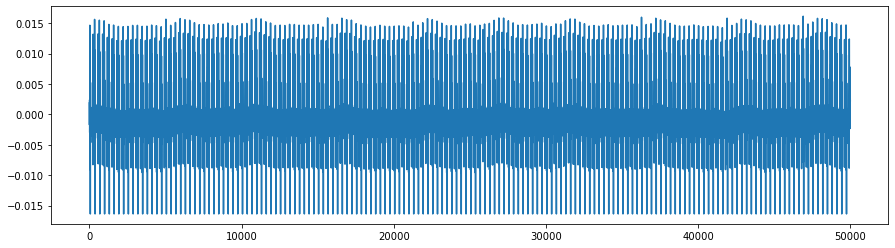

In [4]:
# Plot the 32th(heart) raw eeg data 
plt.figure(figsize=(15,4))
plt.plot(eegdata[31,700000:750000])

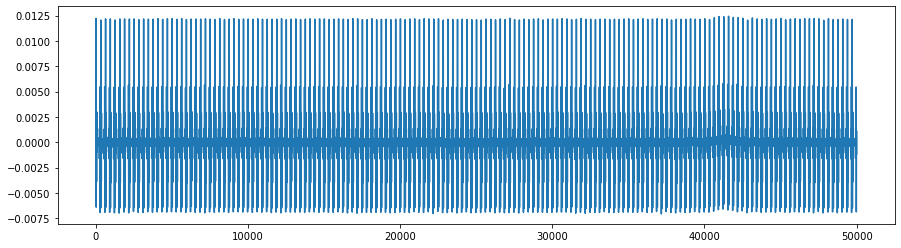

In [5]:
# Plot the 1st(brain) raw eeg data 
plt.figure(figsize=(15,4))
plt.plot(eegdata[0,700000:750000])

Note: Observing the figure above, the brain and the heart figures are presented differently.

#### question(b): Remove gradient and ballistocardiogram artifacts

In [6]:
# Load the eeg image marker
markers = mne.read_annotations("sub-xp210_task-2dNF_run-02_eeg.vmrk")
nmrks = 324
r128s = np.zeros(nmrks)
count = 0

Finding 'sfreq' from header file: /Users/tinan/Downloads/sub-xp210_task-2dNF_run-02_eeg.vhdr


In [7]:
markers

<Annotations | 346 segments: New Segment/ (1), Response/R128 (328), ...>

In [8]:
# count the time points
for i in markers:
    if i['description'] == 'Response/R128' and count < 324:
        r128s[count] = i['onset']
        count = count +1

In [9]:
count

324

In [10]:
start = int(r128s[0]*5000)
end = int(r128s[0]*5000+nmrks*5000)

Note: the starter and the ender of the eeg raw data, which means the latency.

In [11]:
# Reduce the latency
eegltc = eegdata[:,start:end]

In [12]:
# Use the average substraction for removing the gradient artifact
eegltc = np.reshape(eegltc,[64,nmrks,5000])
mean = np.mean(eegltc,axis = 1,keepdims = True)

In [13]:
eegltc = eegltc-mean
eegltc =np.reshape(eegltc,[64,nmrks*5000])

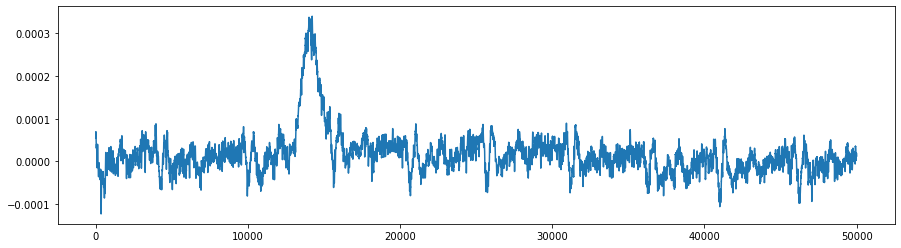

In [14]:
plt.figure(figsize=(15,4))
plt.plot(eegltc[0,700000:750000])

Note: as the figure showed above, there are many flactuations or peaks caused by artifacts.

In [15]:
# find the ica_components before ballistocardiogram manipulation
n_channels = 64
sampling_freq = 5000
info = mne.create_info(n_channels,sampling_freq)
eegltcraw = mne.io.RawArray(eegltc,eeg.info)
eegltcraw.resample(sfreq = 250)
eegltcdata = eegltcraw.get_data()
highpass_raw = eegltcraw.copy()
# we choose the 124 as the upper passband because of the highest frequency of this dataset is below 125
highpass_raw.filter(1,124)
ica = mne.preprocessing.ICA()
ica.fit(highpass_raw)
# the ica.get_sources method will return the sources in the container format passed. 
# It will return The ICA sources time series.
sources = ica.get_sources(eegltcraw).get_data()

Creating RawArray with float64 data, n_channels=64, n_times=1620000
    Range : 0 ... 1619999 =      0.000 ...   324.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)


<ipython-input-15-89828a55c621>:11: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA()


Selecting by non-zero PCA components: 63 components
Fitting ICA took 16.0s.


Note: as the introduction of this assignment PDF document, there are 63 electrode records from the brain which matches this method.

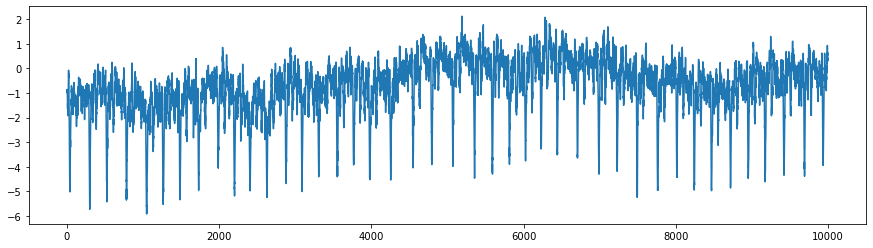

In [16]:
# Plot one channel of the resources
plt.figure(figsize = (15,4))
plt.plot(sources[0,70000:80000])

Note: From the picture above, we recognize that there are many negative peaks among the time seri. Considering the human body artifact, we need to remove the negetive peaks to denoise the signal. To find the peaks, we choose to change mathematical symbol from all negative peaks to real peaks.

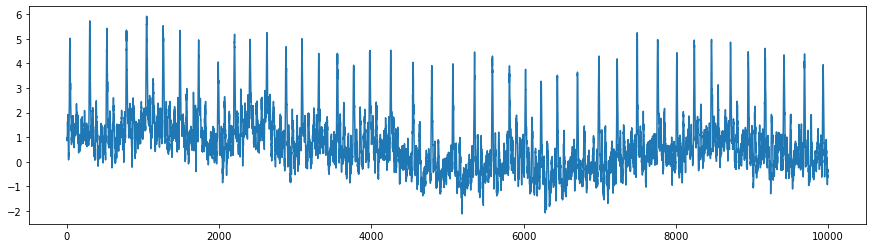

In [17]:
# Choose the 1st channel to find the peaks
bcg = -sources[0,:]
plt.figure(figsize=(15,4))
plt.plot(bcg[70000:80000])

In [18]:
# introduce the find_peaks method to help us find the locations of all peaks.
# distance stands for the required minimal horizontal distance. 
from scipy import signal
peaks = signal.find_peaks(bcg,distance = 200)

Note: the method returns indices of all peaks but the type is tuple-like. We need exact the first element from the tuple.

In [19]:
peaks = peaks[0]
# row indecates the total number of peaks
row = len(peaks)
row

334

In [20]:
bcg.shape

(81000,)

In [21]:
# we treat a simple peak as a time marker so that column is the same as the resample frequency.
column = 250

In [22]:
bcgpks = np.zeros([64,row,column])
bcgpkindx = np.zeros([row,column])

In [23]:
bcgdata = eegltcdata.copy()
bcgdata.shape

(64, 81000)

In [24]:
# remove ballistocardiogram artifact by average substraction
for i in np.arange(1,row-1):
    bcgpks[:,i,:] = eegltcdata[:,peaks[i]-125:peaks[i]+125]
    bcgpkindx[i,:] = np.arange(peaks[i]-125,peaks[i]+125)
bcgpks = bcgpks-np.mean(bcgpks,axis = 1, keepdims = True)

In [25]:
# replace bcg data by the average substracted bcg data corresponding to the position. 
for i in np.arange(1,row-1):
    bcgdata[:,bcgpkindx[i,:].astype(int)] = bcgpks[:,i,:]

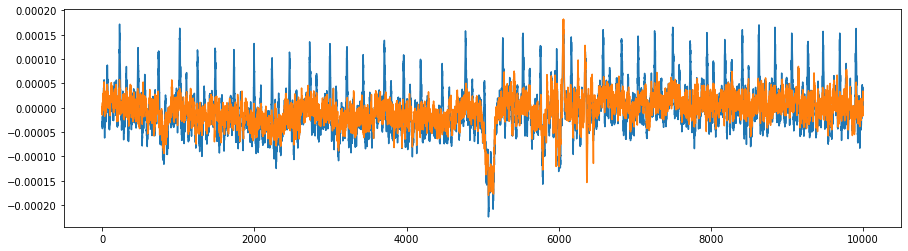

In [62]:
# plot the differences between eeglatency data and the ballistocardiogram removed.
plt.figure(figsize = (15,4))
plt.plot(eegltcdata[60,50000:60000])
plt.plot(bcgdata[60,50000:60000])

#### question(c):Run ICA (figure 5) on EEG signal to isolate the alpha band components 

Creating RawArray with float64 data, n_channels=64, n_times=81000
    Range : 0 ... 80999 =      0.000 ...   323.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)


<ipython-input-63-40d82a89d11a>:5: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA()


Selecting by non-zero PCA components: 63 components
Fitting ICA took 10.6s.


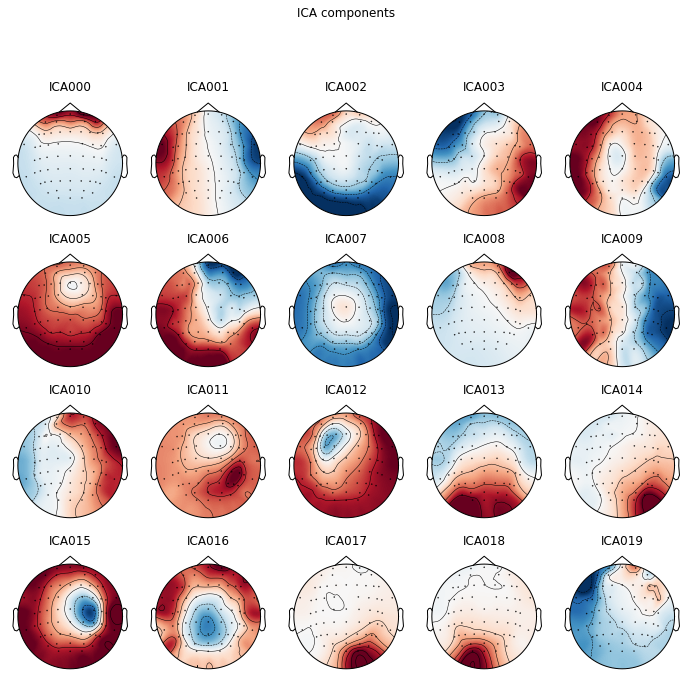

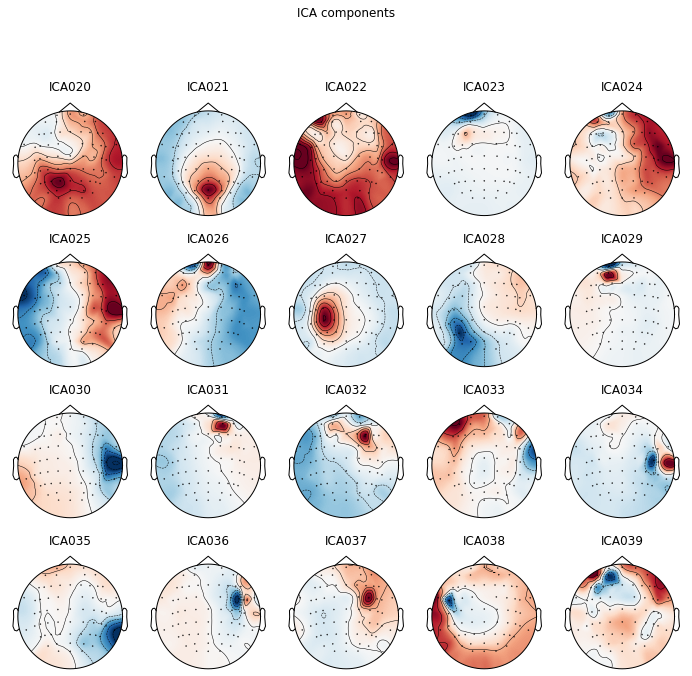

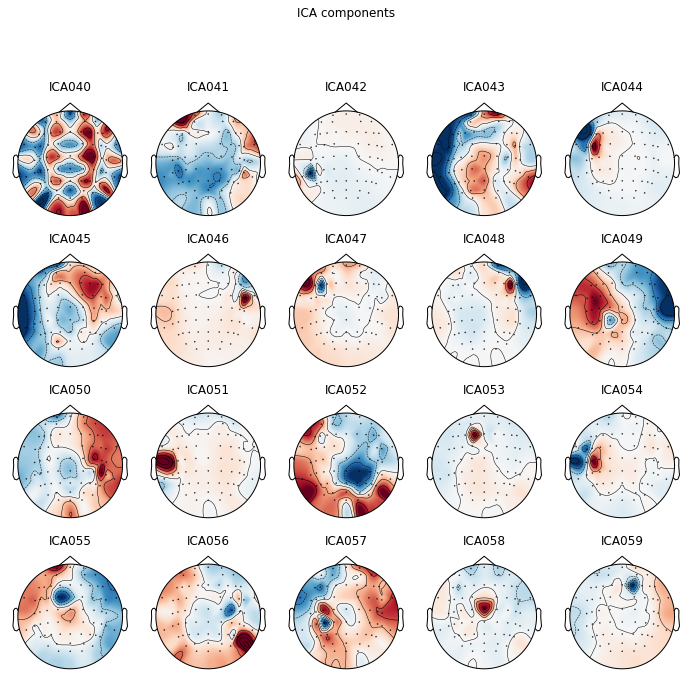

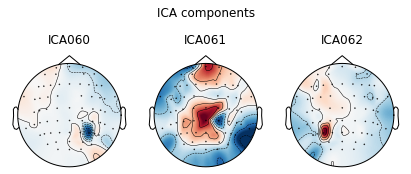

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 421.2x187.56 with 3 Axes>]

In [63]:
eegsub = mne.io.RawArray(bcgdata,eegltcraw.info)
eegsubdata = eegsub.get_data()
highpass_sub = eegsub.copy()
highpass_sub.filter(1,45)
ica = mne.preprocessing.ICA()
ica = icanew.fit(highpass_sub)
ica.plot_components()

Note: same as the PDF introduction, the ICA000,001 are more like artifacts. To our surprise, all figures in our results are less aggressive than the demonstration, but the figue 005,015 and 019 indeed showed obviously brain activity. We tried to manipulate the filter of (1,40),(1,35) and (1,50). The results are all quite different but the same brain circled activity.

Note: the blue lines indecate the eegdata before the ballistocardiogram artifact removed. The orange ones show all peaks(hear beats) are removed.

In [28]:
# use welch to isolate the alpha band components
from scipy.signal import welch

In [29]:
f,Pxx = welch(sources,250)
Pxx.shape

(63, 129)

Text(0, 0.5, 'ICA components')

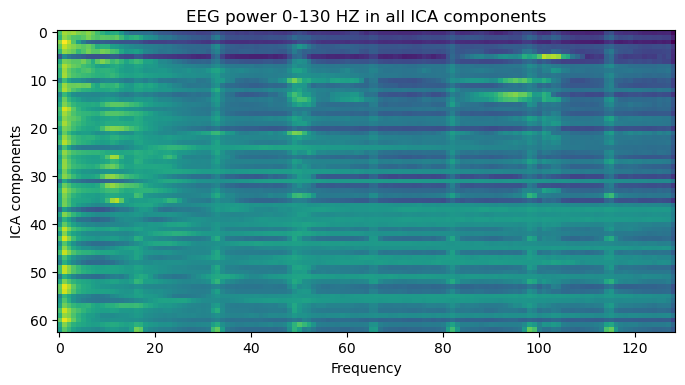

In [30]:
plt.figure(figsize=(15,4),dpi = 100)
plt.imshow(np.log(Pxx))
plt.title('EEG power 0-130 HZ in all ICA components')
plt.xlabel('Frequency')
plt.ylabel('ICA components')

([<matplotlib.axis.XTick at 0x7fcc1421e0a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

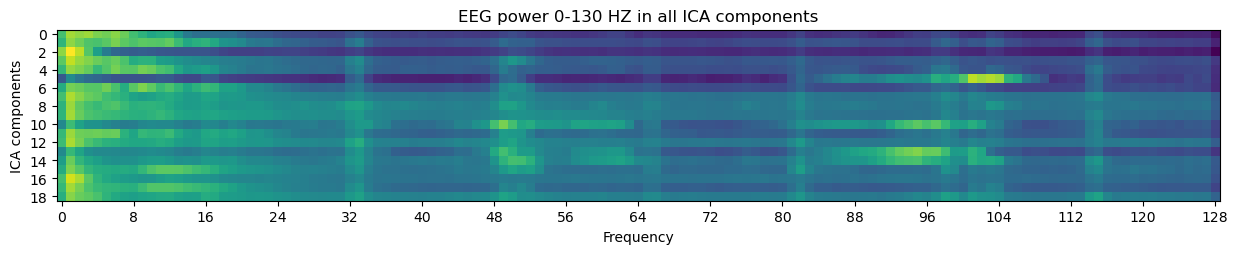

In [31]:
plt.figure(figsize = (15,15),dpi = 100)
plt.imshow(np.log(Pxx[0:19,]))
plt.title('EEG power 0-130 HZ in all ICA components')
plt.xlabel('Frequency')
plt.ylabel('ICA components')
plt.yticks(np.arange(0,19,2))
plt.xticks(np.arange(0,130,8))

Note: The fifth, fifteenth and the ninteenth componts have much brighter green between 8-13 Hz. Also the peaks beyond 32 Hz are noises.

#### question(d): Find the alpha band ICA components by visualizing the topography and power spectrum

([<matplotlib.axis.XTick at 0x7fcc140032e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

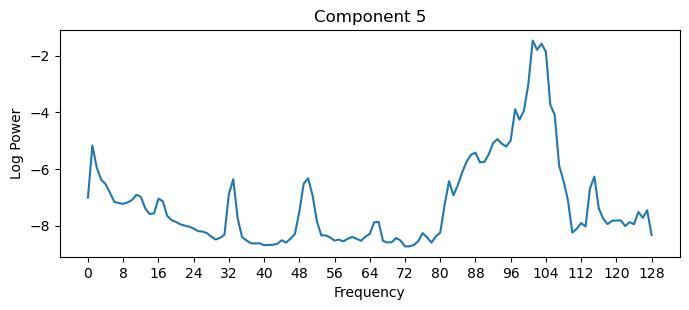

In [32]:
plt.figure(figsize=(8,3),dpi = 100)
plt.plot(np.log(Pxx[5,:]))
plt.xlabel('Frequency')
plt.ylabel('Log Power')
plt.title('Component 5')
plt.xticks(np.arange(0,130,8))

Note: the component 5 has frequency peaks beyond the 80 Hz which means the ica method cannot completely remove the gradient artifacts.

#### question(e):Apply 8-13 Hz bandpass filter to alpha-band component(s)

In [33]:
from scipy.signal import butter, lfilter

In [34]:
sources.shape

(63, 81000)

In [35]:
def bandpass(low, high,fs,data):
    lowf = 8/(0.5*fs)
    highf = 13/(0.5*fs)
    b,a = butter(5,[lowf,highf],btype = 'bandpass')
    y = lfilter(b,a,data)
    return y
sourcesbp = bandpass(8,13,250,sources)

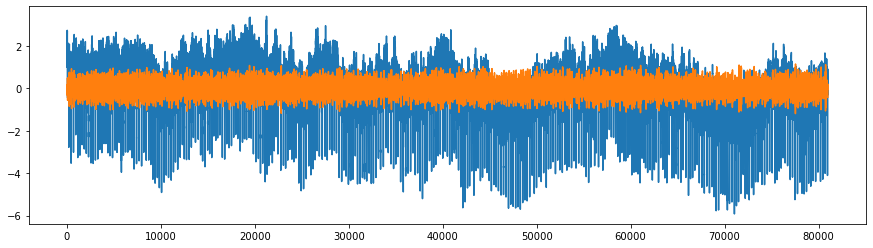

In [36]:
plt.figure(figsize = (15,4))
plt.plot(sources[0,:])
plt.plot(sourcesbp[0,:])

#### Step 3 Denoise the fMRI dataset

#### Question(a): load the bold fmri image

In [37]:
# load bold fmri images
bold = nib.load('sub-xp210_func_sub-xp210_task-2dNF_run-02_bold.nii.gz')
bolddata = bold.get_data()
bolddata.shape

<ipython-input-37-4fb3215dd4fe>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  bolddata = bold.get_data()


(106, 106, 16, 332)

#### question(b):Motion correct

In [38]:
import nipype
from nipype.interfaces import fsl

In [39]:
# use the fsl.mcflirt to register each volumn refereced by the first volumn.
mcflt = fsl.MCFLIRT(in_file='sub-xp210_func_sub-xp210_task-2dNF_run-02_bold.nii.gz', cost='mutualinfo',mean_vol = False,ref_vol = 0)
res = mcflt.run() 

In [40]:
mcfbold = nib.load('sub-xp210_func_sub-xp210_task-2dNF_run-02_bold_mcf.nii.gz')
mcfbolddata = mcfbold.get_data()

<ipython-input-40-4ffa9498b22a>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mcfbolddata = mcfbold.get_data()


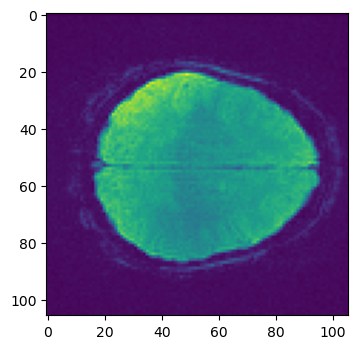

In [41]:
plt.figure(dpi = 100)
plt.imshow(mcfbolddata[:,:,3,0])

#### question(c): Apply 3dbandpass

In [42]:
from nipype.interfaces import afni
bandpass3d = afni.Bandpass(outputtype = 'NIFTI')
bandpass3d.inputs.in_file = 'sub-xp210_func_sub-xp210_task-2dNF_run-02_bold_mcf.nii.gz'
bandpass3d.inputs.highpass = 0.01
bandpass3d.inputs.lowpass = 0.1
bandpass3d.cmdline
resbp = bandpass3d.run()

210710-07:06:29,598 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.598093:++ 3dBandpass: AFNI version=AFNI_21.1.20 (Jun 28 2021) [64-bit]
210710-07:06:29,603 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.598093:++ Authored by: RW Cox
210710-07:06:29,605 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.598093:*+ WARNING: (-: For most purposes, 3dTproject is superior to 3dBandpass :-)
210710-07:06:29,606 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.598093:*+ WARNING: (-: Even better is to use afni_proc.py for pre-processing!! :-)
210710-07:06:29,613 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.613026:*+ WARNING:   If you are performing spatial transformations on an oblique dset,
210710-07:06:29,617 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.613026:  such as /Users/tinan/Downloads/sub-xp210_func_sub-xp210_task-2dNF_run-02_bold_mcf.nii.gz,
210710-07:06:29,619 nipype.interface INFO:
	 stderr 2021-07-10T07:06:29.613026:  or viewing/combining it with volum

Note: I have run this cell before. When I restart the kernel, there will be an error of existed file.

#### Step 4: Combine Datasets 

#### question(a):Resample the smooth, rectified 8-13 Hz bandpass filtered component (step 2e) to 1 Hz (to match fMRI).

In [43]:
from scipy.signal import resample
# resample the filtered component
bpres =np.abs(sourcesbp[0,:])
bpres = resample(bpres,332)
# the bold image delays by 5 seconds to the alpha components
# we roll the array by 4
bpres = np.roll(bpres,4)
bpres

array([0.21286901, 0.22814522, 0.17517353, 0.29104445, 0.11613115,
       0.23223218, 0.26476131, 0.22593794, 0.20277574, 0.25420338,
       0.26482835, 0.20043031, 0.24344642, 0.266616  , 0.18947577,
       0.22032466, 0.23761146, 0.28173174, 0.29383355, 0.21616825,
       0.26753159, 0.23269608, 0.27165429, 0.30612328, 0.29948884,
       0.20766738, 0.26561688, 0.24831003, 0.23666031, 0.27672025,
       0.27995008, 0.26885137, 0.23202479, 0.29452455, 0.27938584,
       0.23347525, 0.23725908, 0.20945107, 0.26256597, 0.23085399,
       0.19762752, 0.22936893, 0.26294719, 0.21350508, 0.17783873,
       0.26840592, 0.21519327, 0.17965094, 0.24845239, 0.25052365,
       0.25084224, 0.23307478, 0.26352364, 0.2328196 , 0.15897297,
       0.16489793, 0.32952406, 0.23265463, 0.16762266, 0.22472681,
       0.26472852, 0.25602895, 0.2354633 , 0.2043293 , 0.30641955,
       0.21923116, 0.2373221 , 0.30786631, 0.22758817, 0.21878294,
       0.28171794, 0.21109894, 0.24961472, 0.1776725 , 0.22101

In [44]:
# reshape the bandpassed bold image
mcfboldbp = nib.load('sub-xp210_func_sub-xp210_task-2dNF_run-02_bold_mcf_bp.nii')
mcfboldbpdata = mcfboldbp.get_data()
mcfboldbpdatares = np.reshape(mcfboldbpdata,[106*106*16,332])
mcfboldbpdatares.shape

<ipython-input-44-f10f71f73994>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mcfboldbpdata = mcfboldbp.get_data()


(179776, 332)

#### question(b):Correlate EEG alpha power (8-13 Hz) with fMRI in each voxel

In [45]:
# calculate the correlation
normbpres = bpres-np.mean(bpres)
normbold = mcfboldbpdatares-np.mean(mcfboldbpdatares,axis = 1,keepdims = True)
normboldsum = np.sum(normbold*normbold,axis = 1)
normbpressum = np.sum(normbpres*normbpres)
correlation = np.sqrt(normboldsum*normbpressum)
correlation = np.array(correlation)
correlation = np.reshape(correlation,[106,106,16])
correlation

array([[[2.4808989e-05, 2.3763721e-05, 2.2627073e-05, ...,
         1.8050334e-05, 1.9763129e-05, 2.1726690e-05],
        [2.4924937e-05, 1.8990100e-05, 2.0062485e-05, ...,
         2.0350741e-05, 1.9072717e-05, 1.9972907e-05],
        [2.4165991e-05, 1.8284554e-05, 2.3969600e-05, ...,
         2.0108639e-05, 2.3209232e-05, 2.2170441e-05],
        ...,
        [3.1708555e+00, 3.7105169e+00, 3.5794213e+00, ...,
         3.6857026e+00, 3.9727321e+00, 3.9907837e+00],
        [3.7157714e+00, 3.3626812e+00, 3.4362578e+00, ...,
         2.9557738e+00, 3.5467365e+00, 3.7269070e+00],
        [3.0438643e+00, 3.1092741e+00, 3.3744483e+00, ...,
         2.6661417e+00, 3.6459916e+00, 3.8661518e+00]],

       [[4.0519386e+01, 3.7887001e+01, 3.7028248e+01, ...,
         2.9216278e+01, 3.7090652e+01, 3.0994862e+01],
        [3.9853767e+01, 3.3825859e+01, 3.4023052e+01, ...,
         3.2227806e+01, 4.0416584e+01, 3.3929283e+01],
        [4.2920261e+01, 3.6756298e+01, 3.7930244e+01, ...,
         3.632

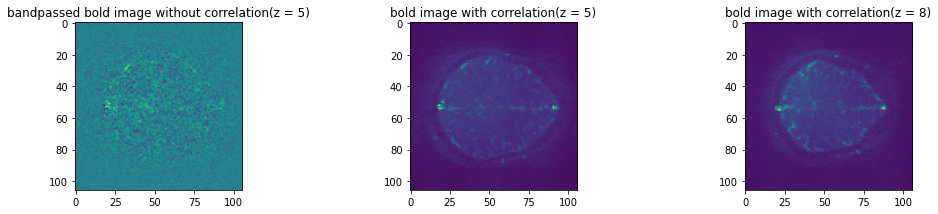

In [46]:
plt.figure(figsize = (15,8))
plt.subplot(1,3,1)
plt.imshow(mcfboldbpdata[:,:,5,0])
plt.title('bandpassed bold image without correlation(z = 5)')
plt.subplot(1,3,2)
plt.imshow(correlation[:,:,5])
plt.title('bold image with correlation(z = 5)')
plt.subplot(1,3,3)
plt.imshow(correlation[:,:,8])
plt.title('bold image with correlation(z = 8)')
plt.subplots_adjust(wspace =1, hspace =3)

Note: Compare the two image above, these two significantly show the difference between with and without correlation. The second image is obviously denoised by EEG alpha.

In [47]:
# save the correlation matrix as an nifti file.
correlationnii = nib.Nifti1Image(correlation.astype(np.float32),bold.affine)
nib.save(correlationnii,'correlation.nii')
correlationvari = nib.load('correlation.nii')
correlationvari = correlationvari.get_data()
correlationvari

<ipython-input-47-92769a592900>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  correlationvari = correlationvari.get_data()


memmap([[[2.4808989e-05, 2.3763721e-05, 2.2627073e-05, ...,
          1.8050334e-05, 1.9763129e-05, 2.1726690e-05],
         [2.4924937e-05, 1.8990100e-05, 2.0062485e-05, ...,
          2.0350741e-05, 1.9072717e-05, 1.9972907e-05],
         [2.4165991e-05, 1.8284554e-05, 2.3969600e-05, ...,
          2.0108639e-05, 2.3209232e-05, 2.2170441e-05],
         ...,
         [3.1708555e+00, 3.7105169e+00, 3.5794213e+00, ...,
          3.6857026e+00, 3.9727321e+00, 3.9907837e+00],
         [3.7157714e+00, 3.3626812e+00, 3.4362578e+00, ...,
          2.9557738e+00, 3.5467365e+00, 3.7269070e+00],
         [3.0438643e+00, 3.1092741e+00, 3.3744483e+00, ...,
          2.6661417e+00, 3.6459916e+00, 3.8661518e+00]],

        [[4.0519386e+01, 3.7887001e+01, 3.7028248e+01, ...,
          2.9216278e+01, 3.7090652e+01, 3.0994862e+01],
         [3.9853767e+01, 3.3825859e+01, 3.4023052e+01, ...,
          3.2227806e+01, 4.0416584e+01, 3.3929283e+01],
         [4.2920261e+01, 3.6756298e+01, 3.7930244e+01, .

In [50]:
# overlay the fmri to the T1 image
from nipype.interfaces import afni
allineate = afni.Allineate(outputtype = 'NIFTI')
allineate.inputs.in_file =  'correlation.nii'
allineate.inputs.reference='sub-xp210_anat_sub-xp210_T1w.nii.gz'
allineate.inputs.out_file = 'correlationreg.nii'
res = allineate.run() 

210710-07:13:52,847 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.846947:++ 3dAllineate: AFNI version=AFNI_21.1.20 (Jun 28 2021) [64-bit]
210710-07:13:52,851 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.846947:++ Authored by: Zhark the Registrator
210710-07:13:52,857 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:*+ WARNING:   If you are performing spatial transformations on an oblique dset,
210710-07:13:52,859 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:  such as /Users/tinan/Downloads/correlation.nii,
210710-07:13:52,860 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:  or viewing/combining it with volumes of differing obliquity,
210710-07:13:52,865 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:  you should consider running: 
210710-07:13:52,869 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:     3dWarp -deoblique 
210710-07:13:52,875 nipype.interface INFO:
	 stderr 2021-07-10T07:13:52.857486:  on this and  o

In [51]:
#load the overlay image
overlay = nib.load('correlation_allineate.nii')
overlaydata = overlay.get_data()
overlaydata.shape

<ipython-input-51-dbfdf3e187a7>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  overlaydata = overlay.get_data()


(176, 512, 512)

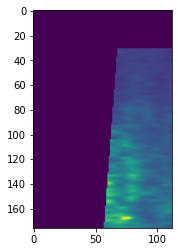

In [52]:
plt.imshow((overlaydata[:,2,400:512]))

Note: we have tried many methods to overlay the conrrelation image to the T1 but failed. Then we installed the fsleye software to visualize the two images. We were exhausted to find the green and blue areas by many tools and methods but still cannot get the point. Finally, we have to screenshot the overlay image displayed by the fsleyes to prove that we really tried very hard to get the result.

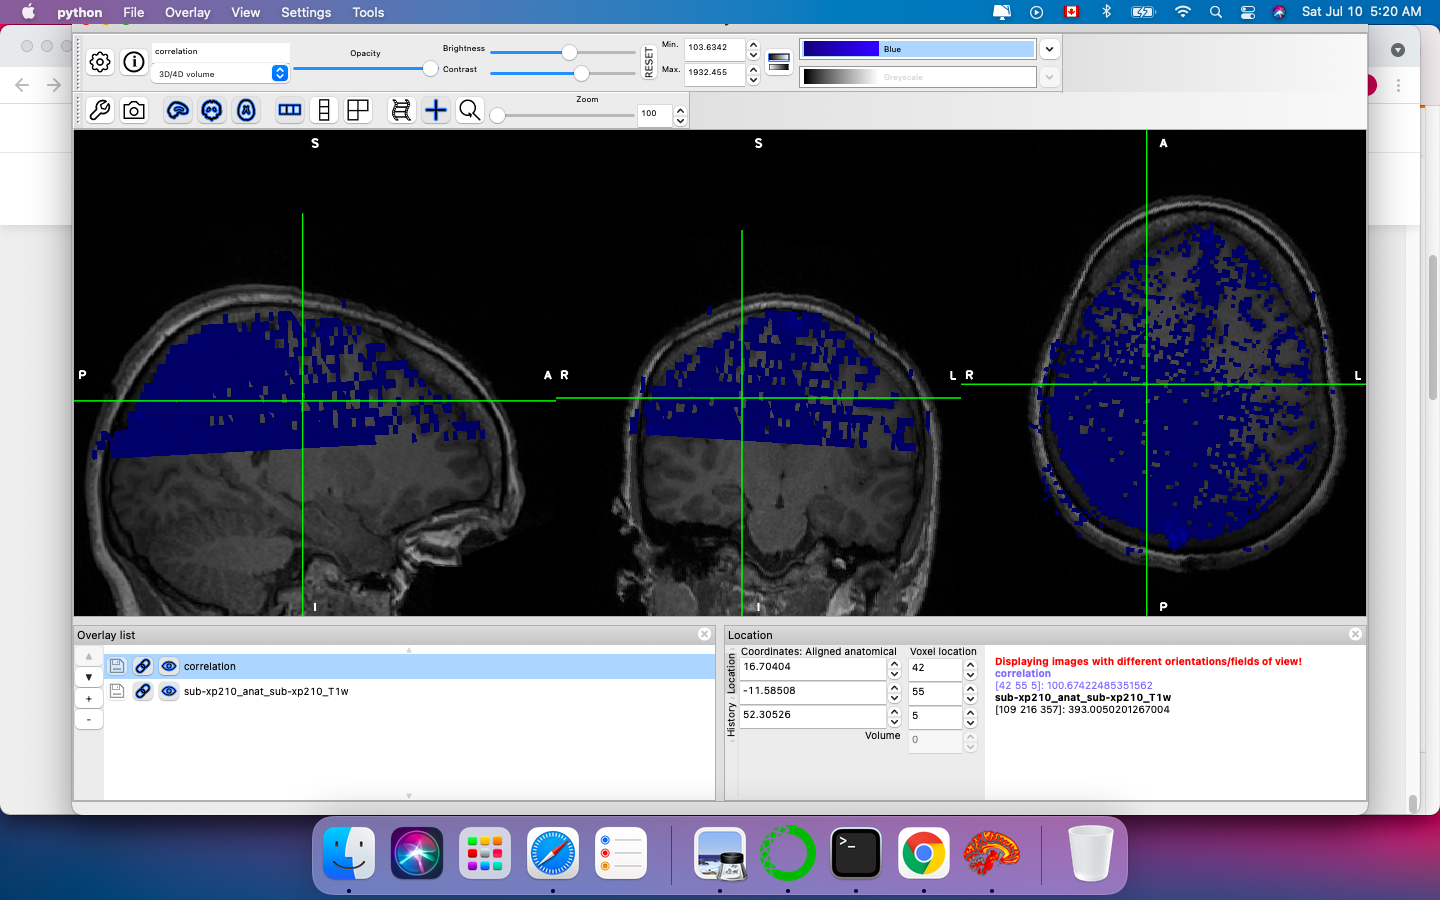

In [53]:
from IPython import display
display.Image("overlayimage.png")

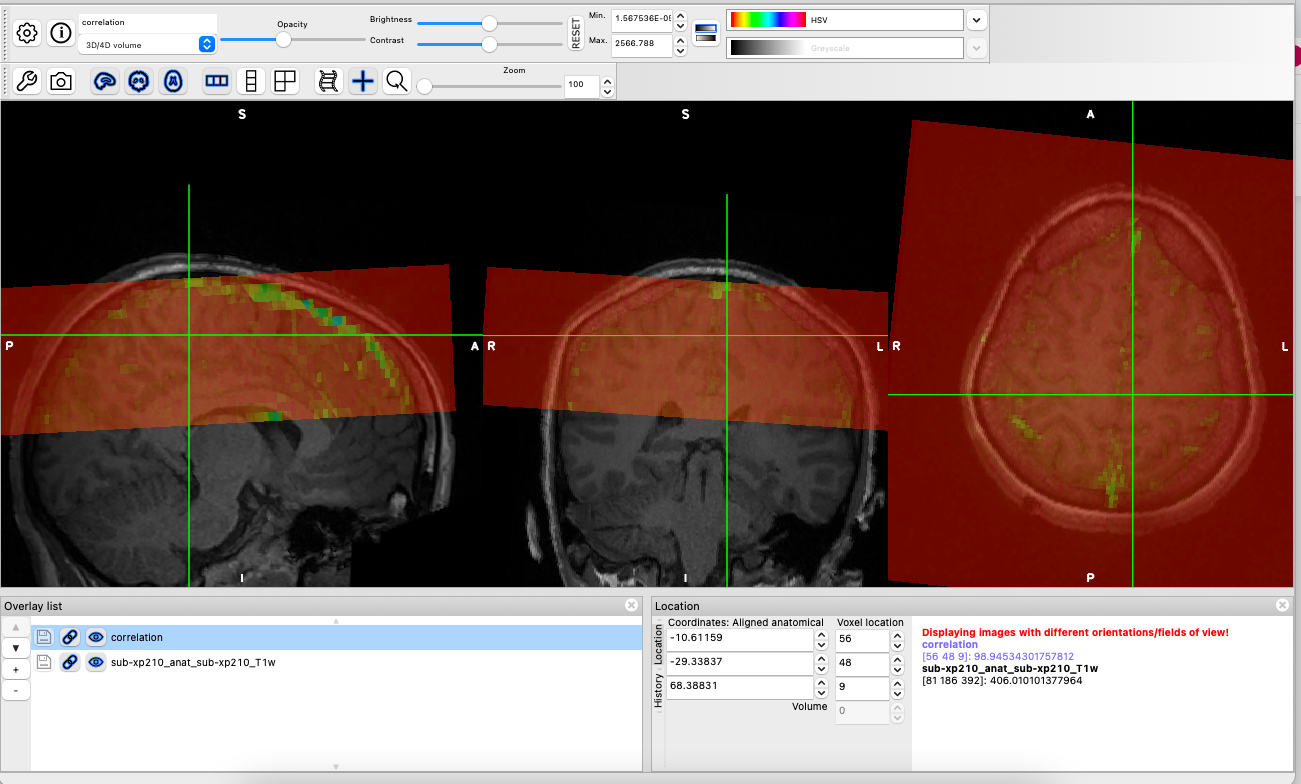

In [54]:
display.Image("overlayimage1.png")

#### question(d) Perform cluster-based multiple comparison testing to eliminate spurious clusters

In [55]:
# Nipype recently offers 3dFWHMx(older version) module to do 3dClustSim
from nipype.interfaces import afni as afp
fwhm = afp.FWHMx()
fwhm.inputs.in_file = 'correlation.nii'
fwhm.cmdline

'3dFWHMx -input correlation.nii -out correlation_subbricks.out > correlation_fwhmx.out'

In [56]:
res = fwhm.run() 

210710-07:25:51,927 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.926976:++ 3dFWHMx: AFNI version=AFNI_21.1.20 (Jun 28 2021) [64-bit]
210710-07:25:51,932 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.926976:++ Authored by: The Bob
210710-07:25:51,946 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:*+ WARNING:   If you are performing spatial transformations on an oblique dset,
210710-07:25:51,947 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:  such as /Users/tinan/Downloads/correlation.nii,
210710-07:25:51,949 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:  or viewing/combining it with volumes of differing obliquity,
210710-07:25:51,955 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:  you should consider running: 
210710-07:25:51,958 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:     3dWarp -deoblique 
210710-07:25:51,960 nipype.interface INFO:
	 stderr 2021-07-10T07:25:51.946282:  on this and  other oblique datas

In [57]:
subbricks = open('correlation_subbricks.out')
subbricks.readlines()

['        5.35637          7.083        9.49022\n']

In [58]:
fwhmx = open('correlation_fwhmx.out')
fwhmx.readlines()

[' 0  0  0    0\n', ' -1  -1  -1    -1\n']

Note: the subbricks are 5.35637,7.083 and 9.49022. The fwhmx are [0,0,0],[-1,-1,-1]